<a href="https://colab.research.google.com/github/DanielGreiner/Masterarbeit/blob/main/Isothermal_steady_state_PFR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [233]:
# @title import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import torch as to
from scipy.integrate import odeint

In [234]:
# @title check library versions
print("tensorflow:" + str(tf.__version__))
print("numpy:" + str(np.__version__))
print("pandas:" + str(pd.__version__))
#print("torch:" + str(to.__version__))

tensorflow:2.13.0
numpy:1.23.5
pandas:1.5.3


# Reaktionen

  \begin{array}{lll}
  \text{Methanol steam reforming (MSR):}&\kern 3pc CH_3OH_{(g)}+H_2O_{(g)}\kern 0.5pc{\overset{k_{1, eff}}{\rightleftharpoons}}\kern 0.5pc 3H_{2(g)}+CO_{2(g)}&\kern 3pc\Delta_r H_{m}^{o}=+49\enspace \frac{kJ}{mol} \\
  \text{Methanol decomposition (MD):}&\kern 3pc CH_3OH_{(g)}\kern 0.5pc {\overset{k_{2, eff}}{\rightleftharpoons}}\kern 0.5pc 2H_{2(g)}+CO_{(g)}&\kern 3pc\Delta_r H_{m}^{o}=+91\enspace \frac{kJ}{mol} \\
  \text{Water gas shift (WGS):}&\kern 3pc CO_{(g)}+H_2O_{(g)}\kern 0.5pc{\overset{k_{3, eff}}{\rightleftharpoons}}\kern 0.5pc H_{2(g)}+CO_{2(g)}&\kern 3pc\Delta_r H_{m}^{o}=-41\enspace \frac{kJ}{mol}
  \end{array}


#Indexing in arrays

\begin{array}{lllll}
H_2 & H_2O & CO & CO_2 & CH_3OH \\
0 & 1 & 2 & 3 & 4 \\
\end{array}

In [235]:
# @title Reaktorkonstanten laden
u = 1.500
A = 3*10**-3
v = u*A
Vges = 50
V0 = 0
steps = 1000
dV = (Vges-V0)/steps
Vspan = np.arange(V0, Vges+dV/2, dV)
z = Vges/A
r = np.sqrt(A/np.pi)

T0 = 273

# print(steps)
# print(Vspan)

In [236]:
# @title Startwerte

C0_H2 = 0
C0_H2O = 0.5
C0_CO = 0.1
C0_CO2 = 0
C0_MeOH = 0.5

IC = np.array([C0_H2, C0_H2O, C0_CO, C0_CO2, C0_MeOH])

In [237]:
# @title Kinetikdaten laden

R = 8.314 #J mol-1 K-1

#BiCat
#MSR
k0_MSR_S = 4.2*10**(-6) # kmol kg-1 h-1
EA_MSR_S = 4.978*1000 #J mol-1
b_MeOH_MSR_S = - 0.428
b_H2O_MSR_S = - 0.949

k0_MSR_M = 2.1*10**(-6) # kmol kg-1 h-1
k0_MSR_K = 2.7*10**(-6) # kmol kg-1 h-1
k0_MSR_L = 3.3*10**(-6) # kmol kg-1 h-1

EA_MSR_MKL = 5.566*1000 #J mol-1
b_MeOH_MSR_MKL = - 0.43
b_H2O_MSR_MKL = - 0.949

MSR = np.array(
    [[k0_MSR_S, EA_MSR_S, b_MeOH_MSR_S, b_H2O_MSR_S],
    [k0_MSR_M, EA_MSR_MKL, b_MeOH_MSR_MKL, b_H2O_MSR_MKL],
    [k0_MSR_K, EA_MSR_MKL, b_MeOH_MSR_MKL, b_H2O_MSR_MKL],
    [k0_MSR_L, EA_MSR_MKL, b_MeOH_MSR_MKL, b_H2O_MSR_MKL]]
)

#MD
k0_MD_S = 5.5*10**(-8) # kmol kg-1 h-1
EA_MD_S = 42.137*1000 #J mol-1
b_MeOH_MD_S = 0.114

k0_MD_M = 1.5*10**(-8) # kmol kg-1 h-1
k0_MD_K = 3.7*10**(-8) # kmol kg-1 h-1
k0_MD_L = 1.1*10**(-7) # kmol kg-1 h-1

EA_MD_MKL = 36.771*1000 #J mol-1
b_MeOH_MD_MKL = 0.109

MD = np.array (
    [[k0_MD_S, EA_MD_S, b_MeOH_MD_S],
    [k0_MD_M, EA_MD_MKL, b_MeOH_MD_MKL],
    [k0_MD_K, EA_MD_MKL, b_MeOH_MD_MKL],
    [k0_MD_L, EA_MD_MKL, b_MeOH_MD_MKL]]
)

#WGS
#Benchmark = B; Benchmark-CuCl = BCC; Benchmark-MB = BMB


k0_WGS_B = 3.1*10**(-10)
EA_B = 104.4*1000 #J mol-1
b_CO_WGS_B = - 0.892
b_H2O_WGS_B = - 0.135


k0_WGS_BCC = 1.6*10**(-9)
EA_BCC = 105.5*1000 #J mol-1
b_CO_WGS_BCC = - 0.836
b_H2O_WGS_BCC = - 0.338

k0_WGS_BMB = 2.82*10**(-10)
EA_BMB = 78.6*1000 #J mol-1
b_CO_WGS_BMB = - 0.685
b_H2O_WGS_BMB = - 0.268

WGS = np.array(
    [[k0_WGS_B, EA_B, b_CO_WGS_B, b_H2O_WGS_B],
    [k0_WGS_BCC, EA_BCC, b_CO_WGS_BCC, b_H2O_WGS_BCC],
    [k0_WGS_BMB, EA_BMB, b_CO_WGS_BMB, b_H2O_WGS_BMB]]
)

ny = np.array(
    [[3, -1, 0, 1, -1],
    [2, 0, 1, 0, -1],
    [1, -1, -1, 1, 0]]
)


#print(MSR)
#print(MD)
#print(WGS)
#print(ny)

# PFTR Isotherm Stationär

ODE: $\frac{dc_x}{dz}$=$\frac{1}{u_0}$⋅$R_x$

$\frac{dc_A}{dV}$=-$\frac{1}{V.}$⋅$R_x$

In [238]:
# @title Funktion der Reaktionen
def ReakFunFull(V, C, T, MSRind, MDind, WGSind):
  dC=np.zeros(len(C))
  C_H2 = C[0]
  C_H2O = C[1]
  C_CO = C[2]
  C_CO2 = C[3]
  C_MeOH = C[4]

  rMSR = np.zeros(len(MSR))
  rMD = np.zeros(len(MD))
  rWGS = np.zeros(len(WGS))

  for i in range(len(MSR)):
    rMSR[i] = MSR[i,0]*np.exp((-MSR[i,1]/R)*(1/T-1/T0), dtype=float)
    rMSR[i] *= np.power(C_MeOH, MSR[i,2], dtype=float) * np.power(C_H2O, MSR[i,3], dtype=float)


  for i in range(len(MD)):
    rMD[i] = MD[i,0]*np.exp((-MD[i,1]/R)*(1/T-1/T0), dtype=float)
    rMD[i] *= np.power(C_MeOH, MD[i,2], dtype=float)

  if C_CO > 0:
   for i in range(len(WGS)):
    rWGS[i] = WGS[i,0]*np.exp((-WGS[i,1]/R)*(1/T-1/T0), dtype=float)
    rWGS[i] *= np.power(C_CO, WGS[i,2], dtype=float) * np.power(C_H2O, WGS[i,3], dtype=float)

  dC[0] = 1/v*(rMSR[MSRind]*ny[0, 0] + rMD[MDind]*ny[1, 0] + rWGS[WGSind]*ny[2, 0])*dV
  dC[1] = 1/v*(rMSR[MSRind]*ny[0, 1] + rMD[MDind]*ny[1, 1] + rWGS[WGSind]*ny[2, 1])*dV
  dC[2] = 1/v*(rMSR[MSRind]*ny[0, 2] + rMD[MDind]*ny[1, 2] + rWGS[WGSind]*ny[2, 2])*dV
  dC[3] = 1/v*(rMSR[MSRind]*ny[0, 3] + rMD[MDind]*ny[1, 3] + rWGS[WGSind]*ny[2, 3])*dV
  dC[4] = 1/v*(rMSR[MSRind]*ny[0, 4] + rMD[MDind]*ny[1, 4] + rWGS[WGSind]*ny[2, 4])*dV

  return dC

# def ReakFunMSRMD (V, C, T, MSRind, MDind):
#   dC=np.zeros(len(C))
#   C_H2 = C[0]
#   C_H2O = C[1]
#   C_CO = C[2]
#   C_CO2 = C[3]
#   C_MeOH = C[4]

#   rMSR = np.zeros(len(MSR))
#   rMD = np.zeros(len(MD))

#   for i in range(len(MSR)):
#     rMSR[i] = MSR[i,0]*np.exp((-MSR[i,1]/R)*(1/T-1/T0), dtype=float)
#     rMSR[i] *= np.power(C_MeOH, MSR[i,2], dtype=float) * np.power(C_H2O, MSR[i,3], dtype=float)


#   for i in range(len(MD)):
#     rMD[i] = MD[i,0]**np.exp((-MD[i,1]/R)*(1/T-1/T0), dtype=float)
#     rMD[i] *= np.power(C_MeOH, MSR[i,2], dtype=float)

#   dC[0] = 1/v*(rMSR[MSRind]*ny[0, 0] + rMD[MDind]*ny[1, 0])*dV
#   dC[1] = 1/v*(rMSR[MSRind]*ny[0, 1] + rMD[MDind]*ny[1, 1])*dV
#   dC[2] = 1/v*(rMSR[MSRind]*ny[0, 2] + rMD[MDind]*ny[1, 2])*dV
#   dC[3] = 1/v*(rMSR[MSRind]*ny[0, 3] + rMD[MDind]*ny[1, 3])*dV
#   dC[4] = 1/v*(rMSR[MSRind]*ny[0, 4] + rMD[MDind]*ny[1, 4])*dV

#   return dC


In [239]:
# @title Euler Verfahren Funktion
def EulFunFull (y, T):
  ytemp = np.zeros([len(Vspan), len(IC)])
  ytemp[0,:] = IC

  for i in range(steps):
    V = Vspan[i]
    y = np.transpose(ytemp[i, :])
    dy = ReakFunFull(V, y, T, 0, 0, 0)
    ytemp[i+1, :] = y + dy

  return ytemp

# def EulFunMSRMD (y, T):
#   ytemp = np.zeros([len(Vspan), len(IC)])
#   ytemp[0,:] = IC

#   for i in range(steps):
#     V = Vspan[i]
#     y = np.transpose(ytemp[i, :])
#     dy = ReakFunMSRMD(V, y, T, 0, 0)
#     ytemp[i+1, :] = y + dy

#   return ytemp


In [240]:
# @title Berechnung mittels ODE-Solver

# Vsp = np.arange(0, Vges, dV)

# def dcdV(C, V):
#   cA = C
#   dCdV = -(1/v)*k*C
#   return dCdV

# sol = odeint(dcdV, cA0, Vsp)

#print(sol[:,0])
#print(Vsp)


In [241]:
# @title main

T = 323

Conc = EulFunFull(IC, T)
print(Conc)

# ConcMSRMD = EulFunMSRMD(IC, T)
# print(ConcMSRMD)

[[0.00000000e+00 5.00000000e-01 1.00000000e-01 0.00000000e+00
  5.00000000e-01]
 [5.67087699e-04 4.99793316e-01 9.99735182e-02 2.06683747e-04
  4.99819798e-01]
 [1.13446443e-03 4.99586529e-01 9.99470254e-02 4.13471217e-04
  4.99639503e-01]
 ...
 [9.23808495e-01 1.68334406e-01 6.44058567e-02 3.31665594e-01
  2.03928550e-01]
 [9.25995211e-01 1.67569810e-01 6.43523204e-02 3.32430190e-01
  2.03217489e-01]
 [9.28194289e-01 1.66801034e-01 6.42986957e-02 3.33198966e-01
  2.02502338e-01]]


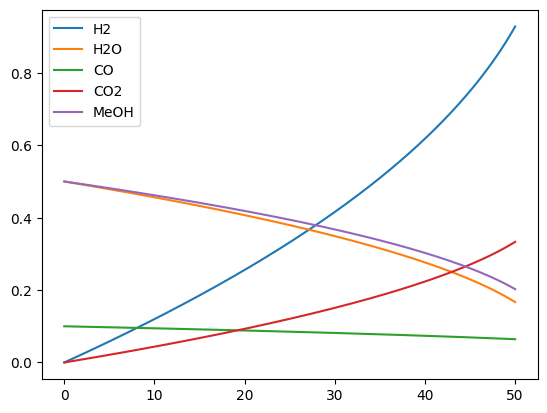

In [242]:
# @title Plots
plt.figure(1)
plt.plot(Vspan, Conc[:,0], label='H2')
plt.plot(Vspan, Conc[:,1], label='H2O')
plt.plot(Vspan, Conc[:,2], label='CO')
plt.plot(Vspan, Conc[:,3], label='CO2')
plt.plot(Vspan, Conc[:,4], label='MeOH')

#plt.axis((0, 15, 0, 2.01))
plt.legend(loc='best')

# plt.figure(2)
# plt.plot(Vspan, ConcMSRMD[:,0], label='H2')
# plt.plot(Vspan, ConcMSRMD[:,1], label='H2O')
# plt.plot(Vspan, ConcMSRMD[:,2], label='CO')
# plt.plot(Vspan, ConcMSRMD[:,3], label='CO2')
# plt.plot(Vspan, ConcMSRMD[:,4], label='MeOH')

# #plt.axis((0, 15, 0, 2.01))
# plt.legend(loc='best')


In [243]:
# @title code testing block || IGNORE

#H = np.array (
#    [[1, 1, 1],
#    [2, 2, 2],
#    [7, 3, 3],
#    [4, 4, 4]])

#Hres = np.zeros(len(H))

#for i in range(len(H)):
#  Hres[i] = H[i,0]*H[i,1]*H[i,2]


#print(Hres)

#A = 3*10**-3
#B = 3*np.power(10,-3, dtype=float)

#print(A)
#print(B)

#C=np.array(
#    [[1, 2, 1, 1, 2],
#    [1, 3, 1, 1, 3]]
#)

#rWGS = np.zeros(2)
#rWGS2 = np.zeros(2)


#for i in range(2):
#  rWGS[i] = WGS[i,0]*np.exp((-WGS[i,1]/R)*(1/T-1/T0))*C[i, 3]**WGS[i,2]*C[i, 2]**WGS[i,3]
#  rWGS2[i] = WGS[i,0]*np.exp((-WGS[i,1]/R)*(1/T-1/T0))*np.power(C[i, 3], WGS[i,2], dtype=float)*np.power(C[i, 2], WGS[i,3], dtype=float)

#print(rWGS)
#print(rWGS2)

#m = np.array([[5, 10]])
#c = np.array([[1, 2], [3, 4]])

#huh = np.multiply(rWGS[0], ny[:, 0])
#huh2 = rWGS[0]*ny[:,0]
#print(huh)
#print(huh2)

#ReakFun test
# ReakFun(t, C, T, MSRind, MDind, WGSind)
#pls = ReakFun(0, IC, 300, 0, 0, 0)
#print(pls)

#np.transpose test
#ktemp = np.zeros([10, 3])
#ktemp[0,:] = 1
#k = np.transpose(ktemp[1, :])
#print(ktemp)
#print(k)
